# Rapid Assessment - Hansen Global Tree Cover Loss 2013-2021

This script contains estimate the total forest area and deforestation rate in 10 years period in the RoI, 3 km buffer, 10 km buffer, and jurisdiction. 

The output from this script will be:
1. Area Estimation (Excel File)
* Forest/Non-Forest Map Area in 2012 and 2022
* Annual Forest Loss in 2013-2021
2. Raster Map (GeoTiff)
* Forest/Non-Forest Map Area in 2012 and 2022
* Annual Forest Loss in 2013-2021

## Initialize geemap module

In [1]:
%matplotlib inline
# Earth Engine Packages
import os
import ee
import geemap
import geopandas as gpd
# Directory Packages
import tkinter as tk
from tkinter import Tk, filedialog, simpledialog, messagebox
# Import data frame calculation package
import pandas as pd
from datetime import datetime, date
from datetime import date
#Import data visualization package in python
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
#Geospatial Packages
import rasterio
from rasterio.plot import show
from matplotlib import colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import numpy as np
from rasterio.transform import from_origin
import matplotlib as mlp
import geoplot as gplt
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

## Data Preparation
Forest is define as land area that has more than certain forest coverage threshold. In this section, input parameter such as forest definition threshold, projection and minimum mapping unit (ha) should be defined
* forest_threshold = minimum forest coverage that is considered as forest
* projection = UTM projection code
* pixels = forest minimum area in a pixel format (2 Ha = 22 pixels, 1 Ha = 11 pixels, 0.5 Ha = 6 pixels)
* loss pixels = minimum mapping area for tree loss (usually same as the minimum forest area)
* roi_directory = specify the directory of the roi using '', eg. 'c:/data/roi/shapefile.shp'
* output_directory = specify the output directory folder using '', eg. 'c/data/ouput'

### Define the input parameters

In [3]:
###### 1 Specify project/region name, Forest threshold and projection
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.

# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")

#Specify forest_threshold
forest_threshold = simpledialog.askinteger("Input", "Specify forest threshold value to define forest",parent=root , 
                                           minvalue =0, maxvalue = 100)

if forest_threshold is not None:
    print("Forest is defined as area with >= ", forest_threshold, ' canopy cover')
else:
    print("Forest Threshold has not specified, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection, ' canopy cover')
else:
    print("Projection has not specified, Restart the code!")
    
# Specify minimum mapping unit - forest
min_forest_map_area = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                              parent=root , minvalue =0, maxvalue = 100)

if min_forest_map_area is not None:
    print("Minimum pixels size is ", min_forest_map_area)
else:
    print("Minimum pixels size has not identified, Restart the code!")

pixels = ee.Number(min_forest_map_area)
    
# Specify minimum mapping unit - forest loss
min_forestloss_map_area = simpledialog.askinteger("Input", "Specify Min pixels area, example: 22 pixels = 2 Ha or 6 pixels = 0.5 Ha",
                                                  parent=root , minvalue =0, maxvalue = 100)

if min_forestloss_map_area is not None:
    print("Minimum pixels size is ", min_forestloss_map_area)
else:
    print("Minimum pixels size has not identified, Restart the code!")

lossPixels = ee.Number(min_forestloss_map_area); 

# Specify column name in RoI attribute table
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("RoI Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")
    
# specify jurisdiction name
jurisdictionname = simpledialog.askstring("Input", "Speficy jurisdiction name",parent=root)

if jurisdictionname is not None:
    print("The script will assess ", jurisdictionname)
else:
    print("Name has not been submitted, Restart the code!")
    
# Specify column name in Jurisdiction attribute table
jrd_column_name = simpledialog.askstring("Input", "Specify columns name in jurisdiction attribute table to define boundary name",parent=root)

if jrd_column_name is not None:
    print("Jurisdiction column name is ", jrd_column_name)
else:
    print("Jurisdiction column has not identified, Restart the code!") 

The script will assess  Gabon RoI
Forest is defined as area with >=  30  canopy cover
All data will be reprojected to  EPSG:32732  canopy cover
Minimum pixels size is  12
Minimum pixels size is  12
RoI Column name is  NAME
The script will assess  Gabon District
Jurisdiction column name is  COUNTRY


In [4]:
# specify directory input folder
roi_directory = filedialog.askopenfile(title="Open ROI Shapefile") # Returns opened path as str
jrd_directory = filedialog.askopenfile(title="Open Jurisdiction Shapefile") # Returns opened path as str
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

In [10]:
# tile scale to avoid memory ran out issue
tileScale = 4

### Reprojection RoI, Buffer Creation, and Jurisdiction

In [11]:
# 3 Region of interest
roi_import = gpd.read_file(roi_directory.name)

# Reproject Shapefile to UTM and convert to ee.FeatureCollection
roi_import_proj  = roi_import.to_crs(crs=projection)

# Convert to ee.FeatureCollection for calculation process
roi = geemap.geopandas_to_ee(roi_import_proj, geodesic=False)

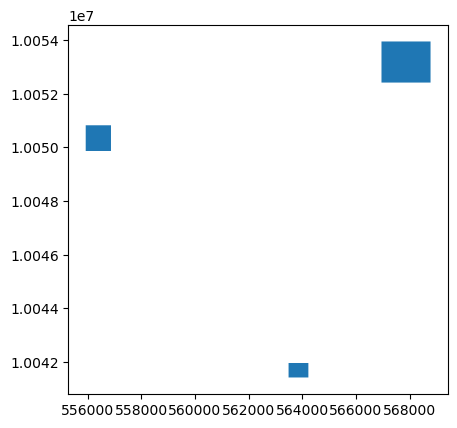

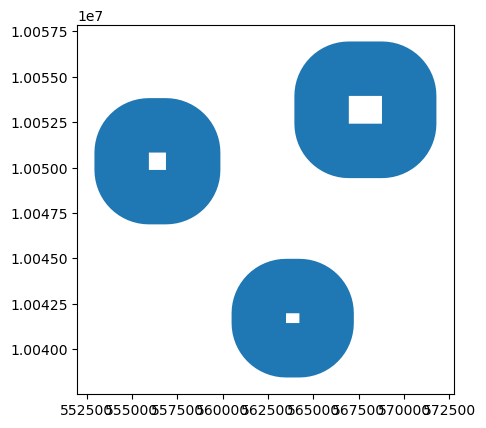

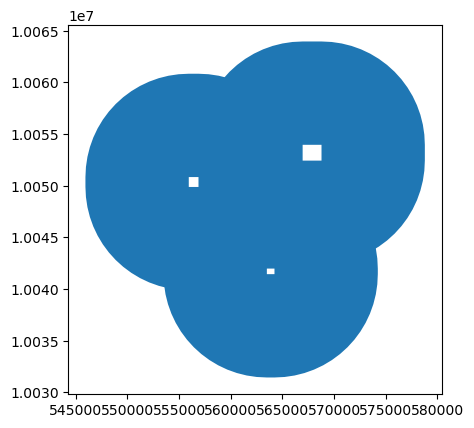

In [12]:
# 4 Create RoI Ring Buffer
buf3km = roi_import_proj.copy()
buf10km = roi_import_proj.copy()

# Create RoI + Buffer 3km
buf3km['geometry'] = buf3km.geometry.buffer(distance = 3000)
# Create RoI + Buffer 10km
buf10km['geometry'] = buf10km.geometry.buffer(distance = 10000)

# create ring buffer through symmetrical difference
# overlapped ring buffer
ring_buf3km = buf3km.copy()
ring_buf3km['geometry'] = buf3km.symmetric_difference(roi_import_proj)
#ring_buf3km = buf3km.overlay(roi_import_proj, how ='symmetric_difference', keep_geom_type=False)
# outer ring buffer
#ring_buf3km = buf3km.overlay(roi_import_proj, how ='difference', keep_geom_type=False)

# overlapped ring buffer
ring_buf10km = buf10km.copy()
ring_buf10km['geometry'] = ring_buf10km.symmetric_difference(roi_import_proj)
#ring_buf10km = buf10km.overlay(roi_import_proj, how ='symmetric_difference', keep_geom_type=False)
# outer ring buffer
#ring_buf10km = buf10km.overlay(roi_import_proj, how ='difference', keep_geom_type=False)

# View shapefiles
#buf3km.plot()
#buf10km.plot()
roi_import_proj.plot()
ring_buf3km.plot()
ring_buf10km.plot()

# convert to feature collection
roi_buffer_3km = geemap.geopandas_to_ee(ring_buf3km, geodesic=False)
roi_buffer_10km = geemap.geopandas_to_ee(ring_buf10km, geodesic=False)

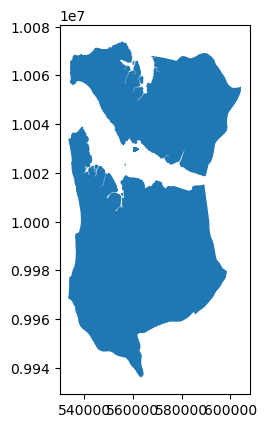

In [13]:
# 5 Jurisdiction
jrd_import = gpd.read_file(jrd_directory.name)

# Reproject Shapefile to UTM and convert to ee.FeatureCollection
jrd_import_proj  = jrd_import.to_crs(crs=projection)

# View jurisdiction shapefile
jrd_import_proj.plot()

# Convert to ee.FeatureCollection for calculation process
jrd = geemap.geopandas_to_ee(jrd_import_proj, geodesic=False)

## Data Processing
Data processing contains the reclassification of Hansen tree cover according to the canopy cover threshold and sieveing at the minimum mapping area unit (Ha) to generate Forest Map in 2000 and 2022; Annual and Accumulative Forest Loss 2001-2022 in the Forest Map 2000 and sieving at the minimum mapping area unit (Ha).

In [14]:
# Import earth engine Hansen image dataset 
Hansen = ee.Image("UMD/hansen/global_forest_change_2021_v1_9")

# Select bands
treeCover = Hansen.select(['treecover2000']);
lossImage = Hansen.select(['loss']);
gainImage = Hansen.select(['gain']);
lossImage_year = Hansen.select(['lossyear']);
landmask = Hansen.select(['datamask']);

#### Reproject Hansen dataset to UTM

In [15]:
# Reproject Image to UTM
treeCover_proj = treeCover.reproject(crs = projection, scale = 30)
lossImage_proj = lossImage.reproject(crs = projection, scale = 30)
lossImage_year_proj = lossImage_year.reproject(crs = projection, scale = 30)
landmask_proj = landmask.reproject(crs = projection, scale = 30)

#### Apply the minimum mapping area unit

In [16]:
# 1 Forest Map in 2000

## Define forest area by >= canopy cover
forest_canopy = treeCover_proj.gte(forest_threshold);
## Mask forest canopy cover threshold
forestCC = forest_canopy.updateMask(forest_canopy.eq(1)).updateMask(landmask_proj.eq(1));

## Apply smoothing with minimum area unit
forestContArea = forestCC.connectedPixelCount().gte(pixels);

## Final forest cover in 2000
ForestExtent_00 = forestCC.updateMask(forestContArea);

#### Forest Loss between 2013 to 2021

In [17]:
# 2 Annual Forest loss 2013-2021:

## Set Forest Loss from 2013-2021
maskerLossYear_1321 = lossImage_year_proj.gte(13);
## Mask Annual Forest Loss
AnnualForestLoss = lossImage_year_proj.updateMask(ForestExtent_00).updateMask(landmask_proj.eq(1)).updateMask(maskerLossYear_1321);
contAnnualLoss = AnnualForestLoss.connectedPixelCount().gte(pixels);
## Masked layer for calculating annual forest loss 
AnnualLossYear_1321 = AnnualForestLoss.updateMask(contAnnualLoss);

In [18]:
# 3 Accumulative Forest Loss 2013-2021

## Set MMU to Estimate accumulative forest 2013-2021
forestLoss_1321 = lossImage_proj.updateMask(ForestExtent_00).updateMask(landmask_proj.eq(1)).updateMask(maskerLossYear_1321);
contLoss = forestLoss_1321.connectedPixelCount().gte(pixels);
AccumForestLoss_1321 = forestLoss_1321.updateMask(contLoss);

#### Forest Cover in 2012 and 2022

In [19]:
# 4 Forest Cover in 2012

## Accumulative forest loss 2001 to 2012 
maskerLoss_0112 = lossImage_year_proj.lte(12);
forestLoss_0112 = lossImage_proj.updateMask(ForestExtent_00.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(maskerLoss_0112);
contLoss_0112 = forestLoss_0112.connectedPixelCount().gte(pixels);
AccumForestLoss_0112 = forestLoss_0112.updateMask(contLoss_0112);

## Specify non-loss during 2001-2012
minLossUnmask_13 = AccumForestLoss_0112.unmask();
notLoss_13 = minLossUnmask_13.select('loss').eq(0);

## Masking forest 2000 with accumulative loss 2001-2012
ForestExtent_12 = ForestExtent_00.updateMask(notLoss_13);

# 5 Forest Cover in 2022

## Accumulative forest loss 2001 to 2021 
maskerLoss_0121 = lossImage_year_proj.gte(1);
forestLoss_0121 = lossImage_proj.updateMask(ForestExtent_00.eq(1)).updateMask(landmask_proj.eq(1)).updateMask(maskerLoss_0121);
contLoss_0121 = forestLoss_0121.connectedPixelCount().gte(pixels);
AccumForestLoss_0121 = forestLoss_0121.updateMask(contLoss_0121);

## Specify non-loss during 2001-2021
minLossUnmask_22 = AccumForestLoss_0121.unmask();
notLoss_22 = minLossUnmask_22.select('loss').eq(0);

## Masking forest 2000 with accumulative loss 2001-2021
ForestExtent_22 = ForestExtent_00.updateMask(notLoss_22);

#### Forest/Non-Forest areas in ROI, 3 km buffer, 10 km buffer, and jurisdiction

In [20]:
# Clip raster by roi, buffer 3km, buffer 10km, and jurisdiction to avoid error

# 1. Forest 2012
RoI_FNF_12_Final = ForestExtent_12.clip(roi)
RoI_FNF_12_Ring_Buffer3km = ForestExtent_12.clip(roi_buffer_3km)
RoI_FNF_12_Ring_Buffer10km = ForestExtent_12.clip(roi_buffer_10km)
Jrd_FNF_12_Final = ForestExtent_12.clip(jrd)

# 2. Forest 2022
RoI_FNF_22_Final = ForestExtent_22.clip(roi)
RoI_FNF_22_Ring_Buffer3km = ForestExtent_22.clip(roi_buffer_3km)
RoI_FNF_22_Ring_Buffer10km = ForestExtent_22.clip(roi_buffer_10km)
Jrd_FNF_22_Final = ForestExtent_22.clip(jrd)

# 3. Annual Forest Loss 2013-2021
RoI_Annual_FL_13_21_Final = AnnualLossYear_1321.clip(roi)
RoI_Annual_FL_13_21_Ring_Buffer3km = AnnualLossYear_1321.clip(roi_buffer_3km)
RoI_Annual_FL_13_21_Ring_Buffer10km = AnnualLossYear_1321.clip(roi_buffer_10km)
Jrd_Annual_FL_13_21_Final = AnnualLossYear_1321.clip(jrd)

# 4. Accumulative Forest Loss 2013-2021
RoI_Accum_FL_13_21_Final = AccumForestLoss_1321.clip(roi)
RoI_Accum_FL_13_21_Ring_Buffer3km = AccumForestLoss_1321.clip(roi_buffer_3km)
RoI_Accum_FL_13_21_Ring_Buffer10km = AccumForestLoss_1321.clip(roi_buffer_10km)
Jrd_Accum_FL_13_21_Final = AccumForestLoss_1321.clip(jrd)

## Interactive Map visualization
Map visualization of Forest/Non-Forest Map in 2000 and 2022; Annual Forest Loss 2001-2022. The map also shows the side by side comparison between Forest Map in 2000 and Forest Map in 2022

### Specify parameter for visualisation

In [21]:
# Visualization Parameters

# Forest - Green
vis_treecover = {'palette': ['000000', '00FF00'], 'max': 100};

# Accumulated Forest Loss
vis_loss = {'palette': ['FF0000']};

# Annual forest loss 2013-2021
vis_loss_year = {'palette': ['blue', 'red'], 'min':13, 'max': 21};

# Forest non forest map
vis_forestnonforest = {'palette': ['#008000']};

# roi polygon
vis_roi = {'color': '#FF0000', 'width': 2,'lineType': 'solid','fillColor': '00000000'}
vis_ring_buffer_3km = {'color': '#0000FF', 'width': 2,'lineType': 'solid','fillColor': '00000000'}
vis_ring_buffer_10km = {'color': '#FFFF00', 'width': 2,'lineType': 'solid','fillColor': '00000000'}

# jurisdiction polygon
vis_jrd = {'color': 'red', 'width': 2,'lineType': 'solid','fillColor': '00000000'}

### Interactive Map

#### Dynamic Map RoI

In [22]:
Map = geemap.Map()

Map.centerObject(roi, 10)

# 1 RoI and buffer
Map.addLayer(roi.style(**vis_roi), {}, "Region of Interest");
Map.addLayer(roi_buffer_3km.style(**vis_ring_buffer_3km), {}, 'RoI Buffer 3km', False);
Map.addLayer(roi_buffer_10km.style(**vis_ring_buffer_10km), {}, 'RoI Buffer 10km', False);

# 2 Forest in 2012
Map.addLayer(RoI_FNF_12_Final, vis_forestnonforest, "RoI - Forest/Non-forest 2012");
Map.addLayer(RoI_FNF_12_Ring_Buffer3km, vis_forestnonforest, "RoI Buffer 3km - Forest/Non-forest 2012", False);
Map.addLayer(RoI_FNF_12_Ring_Buffer10km, vis_forestnonforest, "RoI Buffer 10km- Forest/Non-forest 2012", False);

# 3 Annual Forest Loss in 2013 -2021
Map.addLayer(RoI_Annual_FL_13_21_Final, vis_loss_year, "RoI - Annual Forest Loss 2013-2021");
Map.addLayer(RoI_Annual_FL_13_21_Ring_Buffer3km, vis_loss_year, "RoI Buffer 3km - Annual Forest Loss 2013-2021", False);
Map.addLayer(RoI_Annual_FL_13_21_Ring_Buffer10km, vis_loss_year, "RoI Buffer 10km - Annual Forest Loss 2013-2021", False)

# 4 Accumulative Forest Loss in 2013 -2021
# Map.addLayer(RoI_Accum_FL_13_21_Final, vis_loss, "RoI - Accumulative Forest Loss 2013-2021", False);
# Map.addLayer(RoI_Accum_FL_13_21_Ring_Buffer3km, vis_loss, "RoI Buffer 3km - Accumulative Forest Loss 2013-2021", False);
# Map.addLayer(RoI_Accum_FL_13_21_Ring_Buffer10km, vis_loss, "RoI Buffer 10km - Accumulative Forest Loss 2013-2021", False)

# 5 Forest in 2022
Map.addLayer(RoI_FNF_22_Final, vis_forestnonforest, "RoI - Forest/Non-forest 2022", False);
Map.addLayer(RoI_FNF_22_Ring_Buffer3km, vis_forestnonforest, "RoI Buffer 3km - Forest/Non-forest 2012", False);
Map.addLayer(RoI_FNF_22_Ring_Buffer10km, vis_forestnonforest, "RoI Buffer 10km - Forest/Non-forest 2012", False);

Map

Map(center=[0.4653966800280865, 9.583736496336329], controls=(WidgetControl(options=['position', 'transparent_…

#### Dynamic Map Jurisdiction

In [23]:
Map_jrd = geemap.Map()

Map_jrd.centerObject(jrd, 9)

# 1 Jurisdiction
Map_jrd.addLayer(jrd.style(**vis_jrd), {}, "Jurisdiction");

# 2 Forest in 2012
Map_jrd.addLayer(Jrd_FNF_12_Final, vis_forestnonforest, "Jurisdiction - Forest/Non-forest 2012");

# 3 Annual Forest Loss in 2013 -2021
Map_jrd.addLayer(Jrd_Annual_FL_13_21_Final, vis_loss_year, "Jurisdiction - Annual Forest Loss 2013-2021");

# 4 Accumulative Forest Loss in 2013 -2021
# Map_jrd.addLayer(Jrd_Accum_FL_13_21_Final, vis_loss, "Jurisdiction - Accumulative Forest Loss 2013-2021");

# 5 Forest in 2022
Map_jrd.addLayer(Jrd_FNF_22_Final, vis_forestnonforest, "Jurisdiction - Forest/Non-forest 2022");

# Map_jrd.addLayerControl()
Map_jrd

Map(center=[0.08233268798257111, 9.589448947560554], controls=(WidgetControl(options=['position', 'transparent…

#### Split Panel Map RoI

In [24]:
# Split panel map for RoI forest map in 2012 (left) with forest map in 2022 (right)
Map2 = geemap.Map(basemap='HYBRID')
left_map = geemap.ee_tile_layer(RoI_FNF_12_Final, vis_forestnonforest, "RoI - Forest/Non-forest 2012")
right_map = geemap.ee_tile_layer(RoI_FNF_22_Final, vis_forestnonforest, 'RoI - Forest/Non-forest 2022')
Map2.split_map(left_map, right_map)
Map2.addLayer(roi.style(**vis_roi),{},'roi')
Map2.centerObject(roi, 10)
Map2

Map(center=[0.4653966800280865, 9.583736496336329], controls=(ZoomControl(options=['position', 'zoom_in_text',…

#### Split Panel Map Jurisdiction

In [25]:
# Split panel map for Jurisdiction forest map in 2012 (left) with forest map in 2022 (right)
Map2_jrd = geemap.Map(basemap='HYBRID')
left_map_jrd = geemap.ee_tile_layer(Jrd_FNF_12_Final, vis_forestnonforest, "Jurisdiction - Forest/Non-forest 2012")
right_map_jrd = geemap.ee_tile_layer(Jrd_FNF_22_Final, vis_forestnonforest, 'Jurisdiction - Forest/Non-forest 2022')
Map2_jrd.split_map(left_map_jrd, right_map_jrd)
Map2_jrd.addLayer(jrd.style(**vis_jrd),{},'jurisdiction')
Map2_jrd.centerObject(jrd, 9)
Map2_jrd

Map(center=[0.08233268798257111, 9.589448947560554], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Zonal Statistic
Area estimation in RoI, Buffer 3km, Buffer 10km, and Jurisdiction The outputs will be exported as excel file in the directory folder output

In [26]:
# output directory
out_dir = os.path.expanduser(output_directory+'/RapidScreening_Deforestation_geemap_Hansen')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### 1. Forest Area in 2012 in Rol, Buffer 3km and Buffer 10km

In [30]:
# 1 Region of Interest
FNF12_roi_dir = os.path.join(out_dir, projectname + '_FNF_2012_roi.csv')
geemap.zonal_statistics_by_group(
    RoI_FNF_12_Final,
    roi,
    FNF12_roi_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection,
)
# 2 Buffer 3km
FNF12_Buffer3km_dir = os.path.join(out_dir, projectname + '_FNF_2012_RingBuffer3km.csv')
geemap.zonal_statistics_by_group(
    RoI_FNF_12_Ring_Buffer3km,
    roi_buffer_3km,
    FNF12_Buffer3km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)
# 3 Buffer 10km
FNF12_Buffer10km_dir = os.path.join(out_dir, projectname + '_FNF_2012_RingBuffer10km.csv')
geemap.zonal_statistics_by_group(
    RoI_FNF_12_Ring_Buffer10km,
    roi_buffer_10km,
    FNF12_Buffer10km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)

# 4 Jurisdiction
FNF12_jrd_dir = os.path.join(out_dir, jurisdictionname + '_FNF_2012_jrd.csv')
geemap.zonal_statistics_by_group(
    Jrd_FNF_12_Final,
    jrd,
    FNF12_jrd_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection,
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\KurniaLatifiana\Downloads\RapidScreening_Deforestation_geemap_Hansen\Gabon RoI_FNF_2012_roi.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\KurniaLatifiana\Downloads\RapidScreening_Deforestation_geemap_Hansen\Gabon RoI_FNF_2012_RingBuffer3km.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\KurniaLatifiana\Downloads\RapidScreening_Deforestation_geemap_Hansen\Gabon RoI_FNF_2012_RingBuffer10km.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\KurniaLatifiana\Downloads\RapidScreening_Deforestation_geemap_Hansen\Gabon District_FNF_2012_jrd.csv


### 2. Annual Forest Loss 2013-2021 in Rol, Buffer 3km, Buffer 10km, and Jurisdiction

In [31]:
# 1 Region of Interest
AnnualForestLoss1321_roi_dir = os.path.join(out_dir, projectname + '_AnnualForestLoss_2013_2021_roi.csv')
geemap.zonal_statistics_by_group(
    RoI_Annual_FL_13_21_Final,
    roi,
    AnnualForestLoss1321_roi_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)
# 2 Buffer 3km
AnnualForestLoss1321_Buffer3km_dir = os.path.join(out_dir, projectname + '_AnnualForestLoss_2013_2021_RingBuffer3km.csv')
geemap.zonal_statistics_by_group(
    RoI_Annual_FL_13_21_Ring_Buffer3km,
    roi_buffer_3km,
    AnnualForestLoss1321_Buffer3km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)
# 3 Buffer 10km
AnnualForestLoss1321_Buffer10km_dir = os.path.join(out_dir, projectname + '_AnnualForestLoss_2013_2021_RingBuffer10km.csv')
geemap.zonal_statistics_by_group(
    RoI_Annual_FL_13_21_Ring_Buffer10km,
    roi_buffer_10km,
    AnnualForestLoss1321_Buffer10km_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)

# 4 Jurisdiction
AnnualForestLoss1321_jrd_dir = os.path.join(out_dir, jurisdictionname + '_AnnualForestLoss_2013_2021_jrd.csv')
geemap.zonal_statistics_by_group(
    Jrd_Annual_FL_13_21_Final,
    jrd,
    AnnualForestLoss1321_jrd_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 30,
    crs = projection
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\KurniaLatifiana\Downloads\RapidScreening_Deforestation_geemap_Hansen\Gabon RoI_AnnualForestLoss_2013_2021_roi.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\KurniaLatifiana\Downloads\RapidScreening_Deforestation_geemap_Hansen\Gabon RoI_AnnualForestLoss_2013_2021_RingBuffer3km.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\KurniaLatifiana\Downloads\RapidScreening_Deforestation_geemap_Hansen\Gabon RoI_AnnualForestLoss_2013_2021_RingBuffer10km.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\KurniaLatifiana\Downloads\RapidScreening_Deforestation_geemap_Hansen\Gabon District_AnnualForestLoss_2013_2021_jrd.csv


## Export data
Note: Large size can't be downloaded directly to the directory folder. It has to be exported via google drive

### 1. Area Size in Hectares

In [29]:
# Calculating area size
roi_import_proj['area_Ha'] = roi_import_proj.geometry.area /10000
ring_buf3km['area_Ha'] = ring_buf3km.geometry.area /10000
ring_buf10km['area_Ha'] = ring_buf10km.geometry.area /10000
jrd_import_proj['area_Ha'] = jrd_import_proj.geometry.area /10000

# Export area calculation to csv table
# 1. RoI
area_ha_roi_dir = os.path.join(out_dir, projectname + '_Area_Ha_roi.csv')
roi_import_proj.to_csv(area_ha_roi_dir, index=False)

# 2. Ring buffer 3 km
area_ha_buf3km_dir = os.path.join(out_dir, projectname + '_Area_Ha_RingBuffer3km.csv')
ring_buf3km.to_csv(area_ha_buf3km_dir, index=False)

# 3. Ring buffer 10 km
area_ha_buf10km_dir = os.path.join(out_dir, projectname + '_Area_Ha_RingBuffer10km.csv')
ring_buf10km.to_csv(area_ha_buf10km_dir, index=False)

# 4. Jurisdiction
area_ha_jrd_dir = os.path.join(out_dir, jurisdictionname + '_Area_Ha_jrd.csv')
jrd_import_proj.to_csv(area_ha_jrd_dir, index=False)

### 2. Buffer Shapefile 3km and 10km

In [32]:
ring_buf3km.to_file(os.path.join(out_dir, projectname + '_RingBuffer3km.shp'))
ring_buf10km.to_file(os.path.join(out_dir, projectname + '_RingBuffer10km.shp'))

### 3. Forest Map 2012 and 2022 in RoI, Buffer 3Km, Buffer 10Km, and Jurisdiction

In [33]:
# 1. Forest Map 2012
# 1.1. RoI
geemap.ee_export_image_to_drive(
    RoI_FNF_12_Final,
    description = projectname + '_Forest_2012_roi',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2012_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi.geometry()
)
# 1.2. Buffer 3Km
geemap.ee_export_image_to_drive(
    RoI_FNF_12_Ring_Buffer3km,
    description = projectname + '_Forest_2012_RingBuffer3Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2012_RingBuffer3Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_3km.geometry()
)

# 1.3. Buffer 10Km
geemap.ee_export_image_to_drive(
    RoI_FNF_12_Ring_Buffer10km,
    description = projectname + '_Forest_2012_RingBuffer10Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2012_RingBuffer10Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_10km.geometry()
)

# 1.4. Jurisdiction
geemap.ee_export_image_to_drive(
    Jrd_FNF_12_Final,
    description = jurisdictionname + '_Forest_2012_jrd',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = jurisdictionname + '_Forest_2012_jrd',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = jrd.geometry()
)


# 2. Forest Map 2022
# 2.1. RoI
geemap.ee_export_image_to_drive(
    RoI_FNF_22_Final,
    description = projectname + '_Forest_2022_roi',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2022_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi.geometry()
)
# 2.2. Buffer 3Km
geemap.ee_export_image_to_drive(
    RoI_FNF_22_Ring_Buffer3km,
    description = projectname + '_Forest_2022_RingBuffer3Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2022_RingBuffer3Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_3km.geometry()
)

# 2.3. Buffer 10Km
geemap.ee_export_image_to_drive(
    RoI_FNF_22_Ring_Buffer10km,
    description = projectname + '_Forest_2022_RingBuffer10Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_Forest_2022_RingBuffer10Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_10km.geometry()
)

# 2.4. Jurisdiction
geemap.ee_export_image_to_drive(
    Jrd_FNF_22_Final,
    description = jurisdictionname + '_Forest_2022_jrd',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = jurisdictionname + '_Forest_2022_jrd',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = jrd.geometry()
)

### 4. Annual Forest Loss 2012-2021

In [34]:
# Forest Loss 2013-2021
# 1. RoI
geemap.ee_export_image_to_drive(
    RoI_Annual_FL_13_21_Final,
    description = projectname + '_ForestLoss_2013_2021_roi',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_ForestLoss_2013_2021_roi',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi.geometry()
)
# 2. Buffer 3Km
geemap.ee_export_image_to_drive(
    RoI_Annual_FL_13_21_Ring_Buffer3km,
    description = projectname + '_ForestLoss_2013_2021_RingBuffer3Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_ForestLoss_2013_2021_RingBuffer3Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_3km.geometry()
)

# 3. Buffer 10Km
geemap.ee_export_image_to_drive(
    RoI_Annual_FL_13_21_Ring_Buffer10km,
    description = projectname + '_ForestLoss_2013_2021_RingBuffer10Km',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = projectname + '_ForestLoss_2013_2021_RingBuffer10Km',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = roi_buffer_10km.geometry()
)

# 4. Jurisdiction
geemap.ee_export_image_to_drive(
    Jrd_Annual_FL_13_21_Final,
    description = jurisdictionname + '_ForestLoss_2013_2021_jrd',
    folder = projectname + '_Hansen_Assessment',
    fileNamePrefix = jurisdictionname + '_ForestLoss_2013_2021_jrd',
    scale = 30,
    crs = projection,
    maxPixels= 1e12,
    region = jrd.geometry()
)

# Rapid Assessment - Hansen Data Visualization

## Data Visualization

### Annual Forest Loss 2013-2021

#### Data Pre-processing

In [35]:
# 1. Annual ForestLoss 2013-2021
# 1.1 RoI
annual_forestloss_table = pd.read_csv(AnnualForestLoss1321_roi_dir.replace(os.sep, '/'))
#annual_forestloss_table.head()
annual_forestloss_table_transpose = annual_forestloss_table.T # or df1.transpose()
annual_forestloss_table_transpose.columns = annual_forestloss_table_transpose.loc[roi_column_name]
annual_forestloss_table_transpose = annual_forestloss_table_transpose.loc[annual_forestloss_table_transpose.index.str.contains('Class_')]
annual_forestloss_table_transpose = annual_forestloss_table_transpose.reset_index(level=0)
annual_forestloss_table_transpose = annual_forestloss_table_transpose[annual_forestloss_table_transpose['index'] != 'Class_sum']
annual_forestloss_table_transpose['Year'] = annual_forestloss_table_transpose['index'].str.extract('(\d+)').astype(int)
annual_forestloss_table_transpose = annual_forestloss_table_transpose.sort_values(by=['Year'])
annual_forestloss_table_transpose['Year'] = annual_forestloss_table_transpose['Year'] + 2000
annual_forestloss_table_transpose['Year'] = annual_forestloss_table_transpose['Year'].astype(str)
annual_forestloss_table_transpose['Data'] = 'Deforestation in 2013-2021'
annual_forestloss_table_transpose['Region'] ='RoI'
#annual_forestloss_table_transpose

# 1.2 Buffer 3km
annual_forestloss_3km_table = pd.read_csv(AnnualForestLoss1321_Buffer3km_dir.replace(os.sep, '/'))
#annual_forestloss_table.head()
annual_forestloss_3km_table_transpose = annual_forestloss_3km_table.T # or df1.transpose()
annual_forestloss_3km_table_transpose.columns = annual_forestloss_3km_table_transpose.loc[roi_column_name]
annual_forestloss_3km_table_transpose = annual_forestloss_3km_table_transpose.loc[annual_forestloss_3km_table_transpose.index.str.contains('Class_')]
annual_forestloss_3km_table_transpose = annual_forestloss_3km_table_transpose.reset_index(level=0)
annual_forestloss_3km_table_transpose = annual_forestloss_3km_table_transpose[annual_forestloss_3km_table_transpose['index'] != 'Class_sum']
annual_forestloss_3km_table_transpose['Year'] = annual_forestloss_3km_table_transpose['index'].str.extract('(\d+)').astype(int)
annual_forestloss_3km_table_transpose = annual_forestloss_3km_table_transpose.sort_values(by=['Year'])
annual_forestloss_3km_table_transpose['Year'] = annual_forestloss_3km_table_transpose['Year']  + 2000
annual_forestloss_3km_table_transpose['Year'] = annual_forestloss_3km_table_transpose['Year'].astype(str)
annual_forestloss_3km_table_transpose['Data'] = 'Deforestation in 2013-2021'
annual_forestloss_3km_table_transpose['Region'] ='3km Buffer'
#annual_forestloss_3km_table_transpose

# 1.3 Buffer 10km
annual_forestloss_10km_table = pd.read_csv(AnnualForestLoss1321_Buffer10km_dir.replace(os.sep, '/'))
#annual_forestloss_table.head()
annual_forestloss_10km_table_transpose = annual_forestloss_10km_table.T # or df1.transpose()
annual_forestloss_10km_table_transpose.columns = annual_forestloss_10km_table_transpose.loc[roi_column_name]
annual_forestloss_10km_table_transpose = annual_forestloss_10km_table_transpose.loc[annual_forestloss_10km_table_transpose.index.str.contains('Class_')]
annual_forestloss_10km_table_transpose = annual_forestloss_10km_table_transpose.reset_index(level=0)
annual_forestloss_10km_table_transpose = annual_forestloss_10km_table_transpose[annual_forestloss_10km_table_transpose['index'] != 'Class_sum']
annual_forestloss_10km_table_transpose['Year'] = annual_forestloss_10km_table_transpose['index'].str.extract('(\d+)').astype(int)
annual_forestloss_10km_table_transpose = annual_forestloss_10km_table_transpose.sort_values(by=['Year'])
annual_forestloss_10km_table_transpose['Year'] = annual_forestloss_10km_table_transpose['Year'] + 2000
annual_forestloss_10km_table_transpose['Year'] = annual_forestloss_10km_table_transpose['Year'].astype(str)
annual_forestloss_10km_table_transpose['Data'] = 'Deforestation in 2013-2021'
annual_forestloss_10km_table_transpose['Region'] ='10km Buffer'
#annual_forestloss_10km_table_transpose

# 1.4 Jurisdiction
annual_forestloss_jrd_table = pd.read_csv(AnnualForestLoss1321_jrd_dir.replace(os.sep, '/'))
#annual_forestloss_jrd_table.head()
annual_forestloss_jrd_table_transpose = annual_forestloss_jrd_table.T # or df1.transpose()
annual_forestloss_jrd_table_transpose.columns = annual_forestloss_jrd_table_transpose.loc[jrd_column_name]
annual_forestloss_jrd_table_transpose = annual_forestloss_jrd_table_transpose.loc[annual_forestloss_jrd_table_transpose.index.str.contains('Class_')]
annual_forestloss_jrd_table_transpose = annual_forestloss_jrd_table_transpose.reset_index(level=0)
annual_forestloss_jrd_table_transpose = annual_forestloss_jrd_table_transpose[annual_forestloss_jrd_table_transpose['index'] != 'Class_sum']
annual_forestloss_jrd_table_transpose['Year'] = annual_forestloss_jrd_table_transpose['index'].str.extract('(\d+)').astype(int)
annual_forestloss_jrd_table_transpose = annual_forestloss_jrd_table_transpose.sort_values(by=['Year'])
annual_forestloss_jrd_table_transpose['Year'] = annual_forestloss_jrd_table_transpose['Year'] + 2000
annual_forestloss_jrd_table_transpose['Year'] = annual_forestloss_jrd_table_transpose['Year'].astype(str)
annual_forestloss_jrd_table_transpose['Data'] = 'Deforestation in 2013-2021'
annual_forestloss_jrd_table_transpose['Region'] ='Jurisdiction'
#annual_forestloss_jrd_table_transpose

In [36]:
# Merge loss in RoI
Merge_Loss_RoI = pd.concat([annual_forestloss_table_transpose], ignore_index=True)

# Merge loss in RoI, Buffer 3km, and Buffer 10km
Merge_Loss_RoI_3km_10km = pd.concat([annual_forestloss_table_transpose, annual_forestloss_3km_table_transpose, annual_forestloss_10km_table_transpose], ignore_index=True)

# Merge_Loss in Jurisdiction
Merge_Loss_Jrd = pd.concat([annual_forestloss_jrd_table_transpose], ignore_index=True)

# Merge loss in RoI, Buffer 3km, Buffer 10km, Jurisdiction
Merge_Loss_RoI_3km_10km_Jrd = pd.concat([annual_forestloss_table_transpose, annual_forestloss_3km_table_transpose, annual_forestloss_10km_table_transpose, annual_forestloss_jrd_table_transpose], ignore_index=True)

#### Comparative Graph Annual Forest Loss in RoI

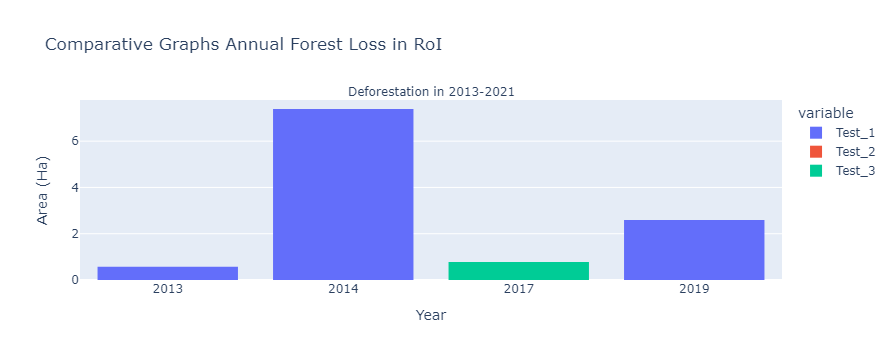

In [37]:
# Helper for specifying y value
y_axis_name = list(Merge_Loss_RoI.columns.values)
y_axis_name.remove('index')
y_axis_name.remove('Year')
y_axis_name.remove('Region')

# Create Histogram
fig = px.histogram(Merge_Loss_RoI, x = 'Year' , y = y_axis_name,   title = "Comparative Graphs Annual Forest Loss in RoI", facet_col= 'Data').update_layout(xaxis_title="Year", yaxis_title="Area (Ha)")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

#### Comparative Graph Annual Forest Loss in Jurisdiction

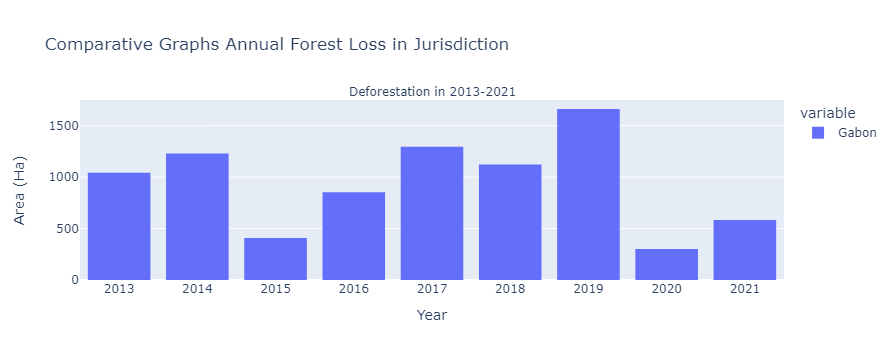

In [38]:
# Helper for specifying y value
y_axis_name_jrd = list(Merge_Loss_Jrd.columns.values)
y_axis_name_jrd.remove('index')
y_axis_name_jrd.remove('Year')
y_axis_name_jrd.remove('Region')

# Create Histogram
fig_jrd = px.histogram(Merge_Loss_Jrd, x = 'Year' , y = y_axis_name_jrd,   title = "Comparative Graphs Annual Forest Loss in Jurisdiction", facet_col= 'Data').update_layout(xaxis_title="Year", yaxis_title="Area (Ha)")
fig_jrd.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

#### Comparative Graph of Forest Loss in RoI, Buffer 3km, Buffer 10km, and Jurisdiction

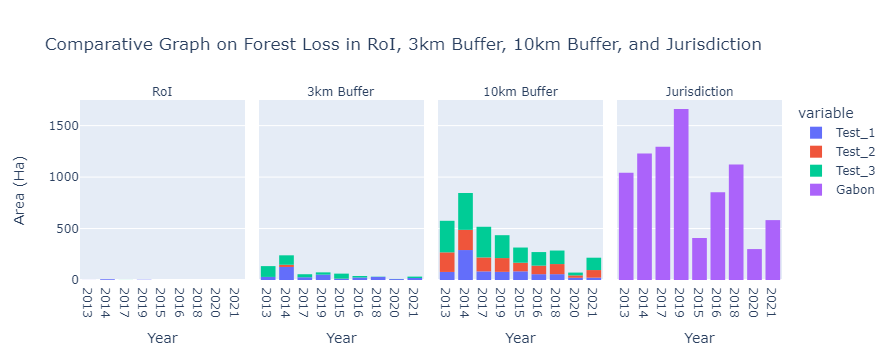

In [39]:
# Helper for specifying y value
y_axis_name_Loss_roi_buffer_jrd = list(Merge_Loss_RoI_3km_10km_Jrd.columns.values)
y_axis_name_Loss_roi_buffer_jrd.remove('index')
y_axis_name_Loss_roi_buffer_jrd.remove('Year')
y_axis_name_Loss_roi_buffer_jrd.remove('Data')

# Create Histogram
fig_roi_buffer_jrd = px.histogram(Merge_Loss_RoI_3km_10km_Jrd, x = 'Year' , y = y_axis_name_Loss_roi_buffer_jrd,   title = "Comparative Graph on Forest Loss in RoI, 3km Buffer, 10km Buffer, and Jurisdiction", facet_col= 'Region').update_layout(xaxis_title="Year", yaxis_title="Area (Ha)")
fig_roi_buffer_jrd.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

## Geospatial Visualisation

### Import Raster Data

In [45]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
raster_directory = filedialog.askdirectory(title = "Specify Raster Folder Directory")

In [46]:
# Import Raster Data RoI
forest12_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_Forest_2012_roi.tif').replace(os.sep, '/'))
AnnualForestLoss1321_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_ForestLoss_2013_2021_roi.tif').replace(os.sep, '/'))

# Import Raster Data Jurisdiction
forest12_jrd_geotiff = rasterio.open(os.path.join(raster_directory, jurisdictionname + '_Forest_2012_jrd.tif').replace(os.sep, '/'))
AnnualForestLoss1321_jrd_geotiff = rasterio.open(os.path.join(raster_directory, jurisdictionname + '_ForestLoss_2013_2021_jrd.tif').replace(os.sep, '/'))

### Data Preparation

#### Forest Loss in RoI

In [47]:
# Create parameters from converting numpy to raster
upperleft_bound_nf = forest12_geotiff.transform * (0, 0)
pixel_size_nf = forest12_geotiff.transform[0]

# overlay forest cover + forest loss
forest_loss_overlay = forest12_geotiff.read(1) * 100 + AnnualForestLoss1321_geotiff.read(1)

new_transform_nf = rasterio.transform.from_origin(upperleft_bound_nf[0],upperleft_bound_nf[1],pixel_size_nf,pixel_size_nf)
new_dataset_nf = rasterio.open(
    os.path.join(raster_directory, projectname + '_ForestLoss_roi.tif').replace(os.sep, '/'), "w+", 
    driver = "GTiff",
    height = forest_loss_overlay.shape[0],
    width = forest_loss_overlay.shape[1],
    count = 1,
    nodata = 0,
    dtype = forest_loss_overlay.dtype,
    crs = projection,
    transform = new_transform_nf
)
new_dataset_nf.write(forest_loss_overlay, 1)
new_dataset_nf.close()

CPLE_AppDefinedError: Deleting C:/Users/KurniaLatifiana/SYSTEMIQ Ltd/GIS Tools - Documents/23_FEASIBILITY RVL_TZA_RUV - AUDD/Python Script/03 Comparison Number Checking All/03 Jupyter Calculation/RapidScreening_Deforestation_geemap_Hansen/Gabon RoI_Hansen_Assessment/Gabon RoI_ForestLoss_roi.tif failed: No such file or directory

#### Forest Loss in Jurisdiction

In [48]:
# Create parameters from converting numpy to raster
upperleft_bound_nf_jrd = forest12_jrd_geotiff.transform * (0, 0)
pixel_size_nf_jrd = forest12_geotiff.transform[0]

# overlay forest cover + forest loss
forest_loss_jrd_overlay = forest12_jrd_geotiff.read(1) * 100 + AnnualForestLoss1321_jrd_geotiff.read(1)

new_transform_nf_jrd = rasterio.transform.from_origin(upperleft_bound_nf_jrd[0],upperleft_bound_nf_jrd[1],pixel_size_nf_jrd,pixel_size_nf_jrd)
new_dataset_nf_jrd = rasterio.open(
    os.path.join(raster_directory, jurisdictionname + '_ForestLoss_jrd.tif').replace(os.sep, '/'), "w+", 
    driver = "GTiff",
    height = forest_loss_jrd_overlay.shape[0],
    width = forest_loss_jrd_overlay.shape[1],
    count = 1,
    nodata = 0,
    dtype = forest_loss_jrd_overlay.dtype,
    crs = projection,
    transform = new_transform_nf_jrd
)
new_dataset_nf_jrd.write(forest_loss_jrd_overlay, 1)
new_dataset_nf_jrd.close()

CPLE_AppDefinedError: Deleting C:/Users/KurniaLatifiana/SYSTEMIQ Ltd/GIS Tools - Documents/23_FEASIBILITY RVL_TZA_RUV - AUDD/Python Script/03 Comparison Number Checking All/03 Jupyter Calculation/RapidScreening_Deforestation_geemap_Hansen/Gabon RoI_Hansen_Assessment/Gabon District_ForestLoss_jrd.tif failed: No such file or directory

### Map

#### Forest Loss Map in RoI

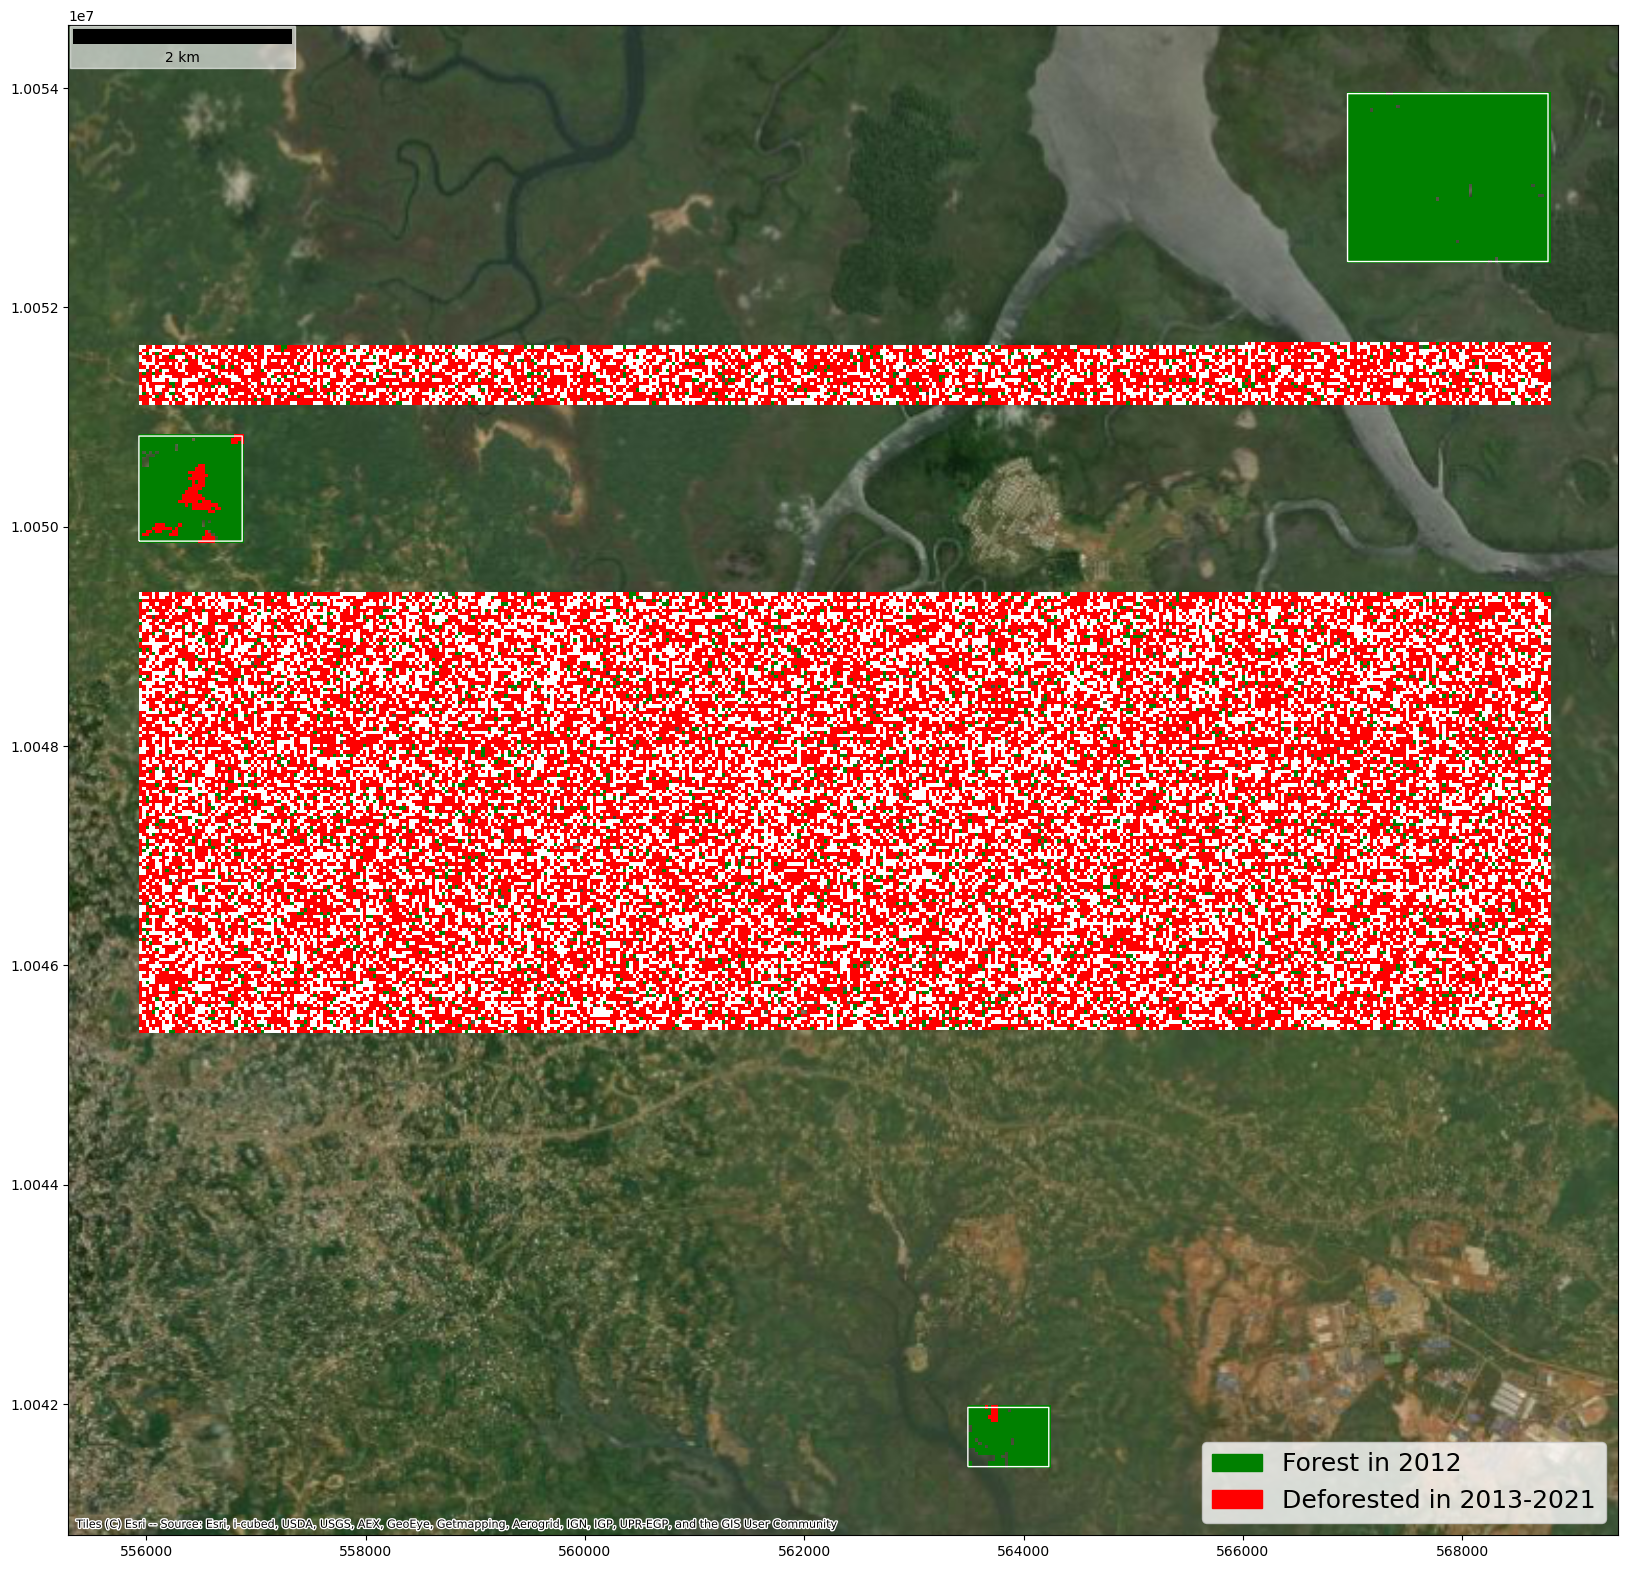

In [49]:
#import overlay raster
AnnualForest_Loss_geotiff = rasterio.open(os.path.join(raster_directory, projectname + '_ForestLoss_roi.tif').replace(os.sep, '/'))

colors_AnnualForestLoss = ['white','green','red']
cmap_AnnualForestLoss = ListedColormap(colors_AnnualForestLoss)
norm_AnnualForestLoss = colors.BoundaryNorm([0,100, 113, 121], 4) # Rename 113-121

fig1, ax1 = plt.subplots(figsize = (20,20))
legend_labels1 = {"green": "Forest in 2012",
                 "red" : "Deforested in 2013-2021"}
patches1 = [Patch(color=color, label=label)
           for color, label in legend_labels1.items()]
ax1.legend(handles=patches1,facecolor="white", prop={'size': 18}, loc='lower right')
ax1.add_artist(ScaleBar(1, box_alpha=0.6, location = 'upper left'))
ax1 = roi_import_proj.plot(figsize=(20, 20), color = None, edgecolor = 'white', facecolor="none", ax = ax1)
ax1 = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=roi_import_proj.crs.to_string(), ax = ax1 )
ax1 = rasterio.plot.show(AnnualForest_Loss_geotiff, ax=ax1, cmap = cmap_AnnualForestLoss, norm = norm_AnnualForestLoss)

#### Forest Loss Map in Jurisdiction

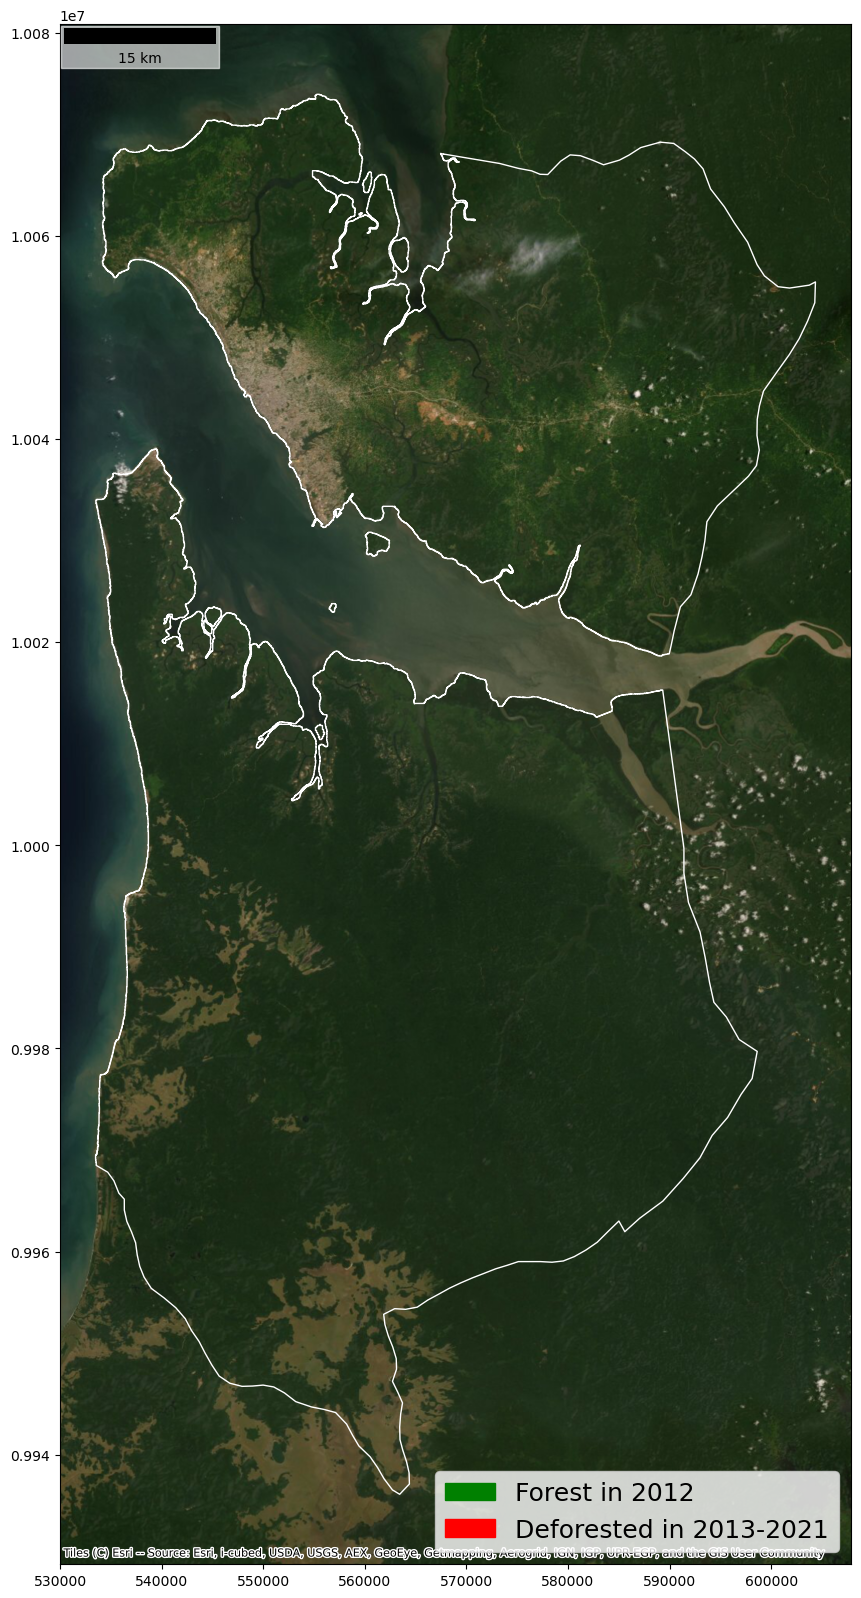

In [50]:
#import overlay raster
AnnualForest_Loss_jrd_geotiff = rasterio.open(os.path.join(raster_directory, jurisdictionname + '_ForestLoss_jrd.tif').replace(os.sep, '/'))

colors_AnnualForestLoss_jrd = ['white','green','red']
cmap_AnnualForestLoss_jrd = ListedColormap(colors_AnnualForestLoss_jrd)
norm_AnnualForestLoss_jrd = colors.BoundaryNorm([0,100, 113, 121], 4) # Rename 113-121

fig2, ax2 = plt.subplots(figsize = (20,20))
legend_labels2 = {"green": "Forest in 2012",
                 "red" : "Deforested in 2013-2021"}
patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]
ax2.legend(handles=patches2,facecolor="white", prop={'size': 18}, loc='lower right')
ax2.add_artist(ScaleBar(1, box_alpha=0.6, location = 'upper left'))
ax2 = jrd_import_proj.plot(figsize=(20, 20), color = None, edgecolor = 'white', facecolor="none", ax = ax2)
ax2 = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=jrd_import_proj.crs.to_string(), ax = ax2 )
ax2 = rasterio.plot.show(AnnualForest_Loss_jrd_geotiff, ax=ax1, cmap = cmap_AnnualForestLoss_jrd, norm = norm_AnnualForestLoss_jrd)